In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import pandas as pd 
from torch.optim.lr_scheduler import StepLR
import torchvision 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
epochs = 150
lr = 1e-4
batchSize = 64

## Q3 dataloader

the following class reads the data for Q3 and creates a torch dataset object for it. With this, you can easily 
use a dataloader to train your model. 

Make sure that the file "hw2_Q3_data.npz" is located properly (in this example, it should be in the same folder as this notebook.

 



In [4]:
class Q3Data(Dataset):
    def __init__(self,trn_tst = 0):
        data = np.load('hw2_Q3_data.npz')
        if trn_tst == 0:
            #trainloader
            self.images = data['arr_0'].T
            self.labels = torch.from_numpy(data['arr_1']).to(device)
        else:
            #testloader
            self.images = data['arr_2'].T
            self.labels = torch.from_numpy(data['arr_3']).to(device)
            
        self.images = torch.from_numpy(np.float32(self.images)/255.0).to(device)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]#.view(28, 28).unsqueeze(0)
        labels = self.labels[idx]
        return sample, labels

Here is an example of how you can create a dataloader for the Q3 data

In [5]:
trainset =   Q3Data(trn_tst=0)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                         shuffle=True, num_workers=0)


testset =   Q3Data(trn_tst=1)  
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=0)

In [6]:
class d_mlp(nn.Module):
    def __init__(self, config='a', act_fn='relu'):
        #Call the __init__ function of the parent nn.module class
        super(d_mlp, self).__init__()
        #Define network layers
        
        if config == 'a':
            self.linear1 = nn.Linear(784, 128)
            self.linear2 = nn.Linear(128, 64)
            self.linear3 = nn.Linear(64, 32)
            self.linear4 = nn.Linear(32, 10)
        
        if act_fn == 'relu':
            self.actfn = nn.ReLU()
        
    def forward(self, x):
        
        out1 = self.actfn(self.linear1(x))
        out2 = self.actfn(self.linear2(out1))
        out3 = self.actfn(self.linear3(out2))
        out4 = self.linear4(out3)

        return out4

In [7]:
import torchvision.models as models

class SingleChannelResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(SingleChannelResNet, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = models.resnet18(pretrained=True)

        # Change the input layer to take Grayscale image, instead of RGB images. 
        # Hence in_channels is set as 1 or 3 respectively
        # original definition of the first layer on the ResNet class
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.model(x)


In [8]:
def get_model(learn_rate=lr, optimizer="adam"):
    model = d_mlp().to(device)
    if optimizer == "sgd": 
        opt = optim.SGD(model.parameters(), lr=learn_rate)
    elif optimizer == "adam":
        opt = optim.Adam(model.parameters(), lr=learn_rate)
    return model, opt

In [9]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean().item()

def fit(epochs, model, loss_func, opt, train_dl, test_dl, schedule=None):
    if schedule is not None:
        scheduler = StepLR(opt, step_size=schedule, gamma=0.1)
    pbar = tqdm(range(epochs))
    loss_list = []
    acc_list = []
    for epoch in pbar:

        model.train()
        for xb, yb in train_dl:
            tr_loss, tr_num = loss_batch(model, loss_func, xb, yb, opt)
            pred = model(xb)
            tr_acc = accuracy(pred, yb)
                
        if schedule is not None:
            scheduler.step()
        correct = 0
        total = 0
        
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc = correct / total

        train_loss = np.sum(np.multiply(tr_loss, tr_num)) / np.sum(tr_num)
        loss_list.append(train_loss)
        acc_list.append([tr_acc, test_acc])
        pbar.set_description("Epoch %i" % epoch)
    
    return([loss_list, acc_list])

In [10]:
model, opt = get_model(learn_rate=1e-4)

In [11]:
loss_fn = nn.CrossEntropyLoss()

In [12]:
loss, acc = fit(epochs, model, loss_fn, opt, trainloader, testloader)

Epoch 149: 100%|██████████| 150/150 [04:53<00:00,  1.96s/it]


In [13]:
df_q3 = pd.DataFrame(loss, columns =['Training Loss']) 
acc_q3 = pd.DataFrame(acc, columns =['Training Accuracy', 'Test Accuracy']) 

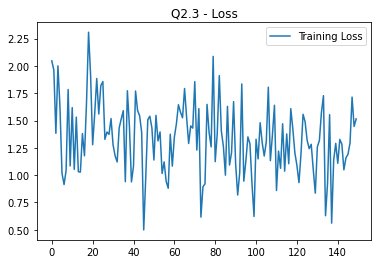

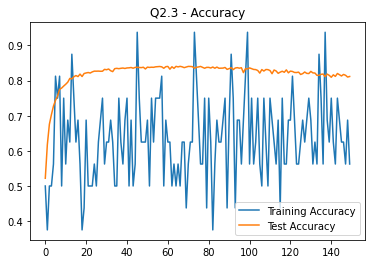

In [14]:
df_q3.plot(title='Q2.3 - Loss')
acc_q3.plot(title='Q2.3 - Accuracy')

In [15]:
acc_q3.max()

Training Accuracy    0.937500
Test Accuracy        0.840433
dtype: float64

In [37]:
images = images.view(batchSize, 28, 28)

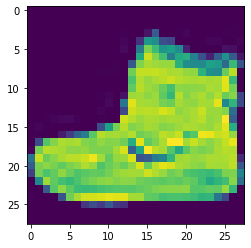

In [38]:
plt.imshow(images[0].squeeze().cpu())

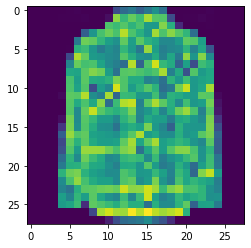

In [41]:
tdataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.view(batchSize, 28, 28)
plt.imshow(images[0].squeeze().cpu())

In [39]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 70 %


In [40]:
len(testloader)

1875